# DA for DMD cylinder_model.py

In [1]:
import random
from time import perf_counter

import torch
from torch import nn
import torch.nn.functional as F
import numpy
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


def set_device():
    """
    Use CPU if cuda device is not available
    setup tf32 for faster GPU computation
    """
    if torch.cuda.device_count() == 0:
        return "cpu"
    torch.set_float32_matmul_precision("high")
    return "cuda"


set_seed(42)
g = torch.Generator()
g.manual_seed(42)
device = set_device()
device

/scratch_dgxl/wy524/miniconda3/envs/irp-env/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


'cpu'

In [2]:
from cylinder_model import CYLINDER_C_FORWARD

forward_model = CYLINDER_C_FORWARD()
forward_model.load_state_dict(torch.load('cyl_model_weights/forward_model.pt', weights_only=True, map_location=device))
forward_model.C_forward = torch.load('cyl_model_weights/C_forward.pt', weights_only=True, map_location=device)
forward_model.eval()

print(forward_model)

CYLINDER_C_FORWARD(
  (K_S): CYLINDER_K_S(
    (Conv2D_size7_1): Conv2d(2, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (Conv2D_size5_1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (Conv2D_size3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Conv2D_size3_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Conv2D_size3_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=4096, out_features=512, bias=True)
  )
  (K_S_preimage): CYLINDER_K_S_preimage(
    (linear): Linear(in_features=512, out_features=4096, bias=True)
    (ConvTranspose2D_size3_1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ConvTranspose2D_size3_2): ConvTranspose2d(128, 6

In [3]:
from Dataset import CylinderDynamicsDataset

foward_step = 12

val_idx = 3

cyl_train_dataset = CylinderDynamicsDataset(data_path="../../../data/cylinder/cylinder_train_data.npy",
                seq_length = foward_step,
                mean=None,
                std=None)
    
cyl_val_dataset = CylinderDynamicsDataset(data_path="../../../data/cylinder/cylinder_val_data.npy",
            seq_length = foward_step,
            mean=cyl_train_dataset.mean,
            std=cyl_train_dataset.std)

denorm = cyl_val_dataset.denormalizer()

Loaded Cylinder data with shape: (39, 1000, 2, 64, 64)
dataset total samples: 38532
Loaded Cylinder data with shape: (10, 1000, 2, 64, 64)
dataset total samples: 9880


In [4]:
groundtruth = cyl_val_dataset.data[val_idx, ...]
groundtruth = torch.from_numpy(groundtruth)

groundtruth.shape

torch.Size([1000, 2, 64, 64])

In [5]:
def visualize_image(image_2d, title='Image', cmap='viridis'):
    if isinstance(image_2d, torch.Tensor):
        image_2d = image_2d.detach().cpu().numpy()

    plt.figure(figsize=(2, 2))
    plt.imshow(image_2d, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
import os
import sys
import numpy as np

class SparseObservationHandler:
    
    def __init__(self, observation_ratio: float = 0.1, seed: int = 42):
        self.observation_ratio = observation_ratio
        self.seed = seed
        self.observation_mask = None
        self.observation_indices = None
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def generate_observation_mask(self, image_shape):
        if len(image_shape) == 4:  # (B, C, H, W)
            _, C, H, W = image_shape
        elif len(image_shape) == 3:  # (C, H, W)
            C, H, W = image_shape
        else:
            raise ValueError(f"Unsupported image shape: {image_shape}")
        
        total_pixels = C * H * W
        num_observations = int(total_pixels * self.observation_ratio)
        
        observation_indices = torch.randperm(total_pixels)[:num_observations]
        
        mask = torch.zeros(total_pixels, dtype=torch.bool)
        mask[observation_indices] = True
        
        self.observation_mask = mask
        self.observation_indices = observation_indices
        
        return mask, observation_indices
    
    def apply_sparse_observation(self, full_image, mask=None):
        if mask is None:
            mask = self.observation_mask
        
        flat_image = full_image.flatten()
        observed_values = flat_image[mask]
        
        return observed_values

### DA

In [7]:
import torchda

In [8]:
# del cyl_train_dataset
# del cyl_val_dataset

In [9]:
observation_ratio = 0.15
obs_handler = SparseObservationHandler(observation_ratio=observation_ratio, seed=42)

In [10]:
start_da_end_idxs = (740, 750, 770)

time_obs = [
    start_da_end_idxs[1], # 750
    start_da_end_idxs[1] + 10, # 760
]
gaps = [10] * (len(time_obs) - 1)

full_y_data = [
    cyl_val_dataset.normalize(groundtruth[i, ...])
    for i in range(groundtruth.shape[0])
    if i in time_obs
]

full_y_data = torch.cat(full_y_data).to(device)

In [11]:
print(full_y_data.shape)

torch.Size([2, 2, 64, 64])


In [12]:
sample_image_shape = full_y_data[0].shape  # (C, H, W)
mask, indices = obs_handler.generate_observation_mask(sample_image_shape)
mask = mask.to(device)

sparse_y_data = []
for full_img in full_y_data:
    sparse_obs = obs_handler.apply_sparse_observation(full_img, mask)
    sparse_y_data.append(sparse_obs)
sparse_y_data = torch.stack(sparse_y_data)

print(f"Original observation shape: {full_y_data.shape}")
print(f"Sparse observation shape: {sparse_y_data.shape}")
print(f"Observation ratio: {sparse_y_data.shape[1] / full_y_data[0].numel():.3f}")

Original observation shape: torch.Size([2, 2, 64, 64])
Sparse observation shape: torch.Size([2, 1228])
Observation ratio: 0.150


In [13]:
def H_sparse(x):
    x_reconstructed = forward_model.K_S_preimage(x)
    sparse_obs = obs_handler.apply_sparse_observation(x_reconstructed.squeeze(), mask)
    return sparse_obs.unsqueeze(0)

In [14]:
latent_dim = forward_model.C_forward.shape[0]
B = torch.eye(latent_dim, device=device)

obs_dim = sparse_y_data.shape[1]
R = 1e-2 * torch.eye(obs_dim, device=device)

print(f"Background covariance B shape: {B.shape}")
print(f"Observation covariance R shape: {R.shape}")

Background covariance B shape: torch.Size([512, 512])
Observation covariance R shape: torch.Size([1228, 1228])


In [15]:
def dmd_warpper(z_t, time_fw=None, *args):
    if time_fw == None:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        y0 = z_t
        y = forward_model.latent_forward(y0)
        
    else:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        y0 = z_t
        y = torch.empty((z_t.shape[1], time_fw.shape[0]), device=z_t.device)
        y[:, 0] = y0
        for i in range(1, int(time_fw.shape[0])):
            y0 = forward_model.latent_forward(y0)
            y[:, i] = y0
        
        y = y.T.unsqueeze_(1)
    return y

In [16]:
case_to_run = (
    torchda.CaseBuilder()
    .set_observation_time_steps(time_obs)
    .set_gaps(gaps)
    .set_forward_model(dmd_warpper)
    .set_observation_model(H_sparse)
    .set_background_covariance_matrix(B)
    .set_observation_covariance_matrix(R)
    .set_observations(sparse_y_data)
    .set_optimizer_cls(torch.optim.Adam)
    .set_optimizer_args({"lr": 2.5})
    .set_max_iterations(1000)
    .set_algorithm(torchda.Algorithms.Var4D)
    .set_device(torchda.Device.CPU)
    .set_output_sequence_length(1)
)

In [17]:
outs_4d_da = []

start_time = perf_counter()
for i in range(groundtruth.shape[0]):
    if i < start_da_end_idxs[0]:
        continue
    elif i == start_da_end_idxs[-1] + 1:
        break
    print(f"Processing step {i}")
    
    if i == start_da_end_idxs[0]:
        out = forward_model.K_S(cyl_val_dataset.normalize(groundtruth[i]))
        continue
        
    if i == start_da_end_idxs[1]:
        case_to_run.set_background_state(out.ravel())
        result = case_to_run.execute()
        out = result["assimilated_state"]
        
        intermediate_results = result["intermediate_results"]
        final_cost = intermediate_results["J"][-1]
        print(f"Final cost function: {final_cost}")
        print(f"Number of iterations: {len(intermediate_results['J'])}")
        
    outs_4d_da.append(out)
    out = dmd_warpper(out)
    print("=" * 50)

print(f"Sparse observation 4D-Var time: {perf_counter() - start_time}s")

Processing step 740
Processing step 741
Processing step 742
Processing step 743
Processing step 744
Processing step 745
Processing step 746
Processing step 747
Processing step 748
Processing step 749
Processing step 750


[W708 22:14:06.957791866 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Timestamp: 2025-07-08 22:14:11.102583, Iterations: 0, Jb: 0.0, Jo: 226115.84375, J: 226115.84375, Norm of J gradient: 10315.09375
Timestamp: 2025-07-08 22:14:11.145936, Iterations: 1, Jb: 3200.0, Jo: 136881.40625, J: 140081.40625, Norm of J gradient: 4946.728515625
Timestamp: 2025-07-08 22:14:11.181623, Iterations: 2, Jb: 8345.5107421875, Jo: 95309.21875, J: 103654.7265625, Norm of J gradient: 3813.510498046875
Timestamp: 2025-07-08 22:14:11.217350, Iterations: 3, Jb: 13318.3583984375, Jo: 72908.1640625, J: 86226.5234375, Norm of J gradient: 1967.070556640625
Timestamp: 2025-07-08 22:14:11.252648, Iterations: 4, Jb: 17649.18359375, Jo: 63235.44921875, J: 80884.6328125, Norm of J gradient: 1197.0654296875
Timestamp: 2025-07-08 22:14:11.288747, Iterations: 5, Jb: 21356.419921875, Jo: 52466.8359375, J: 73823.2578125, Norm of J gradient: 1038.732177734375
Timestamp: 2025-07-08 22:14:11.324787, Iterations: 6, Jb: 24392.880859375, Jo: 43578.99609375, J: 67971.875, Norm of J gradient: 980.476

In [18]:
outs_no_4d_da = []
start_time = perf_counter()
with torch.no_grad():
    for i in range(groundtruth.shape[0]):
        if i < start_da_end_idxs[0]:
            continue
        elif i == start_da_end_idxs[-1] + 1:
            break
        print(i)
        if i == start_da_end_idxs[0]:
            out = forward_model.K_S(cyl_val_dataset.normalize(groundtruth[i])) # 750
            continue
        outs_no_4d_da.append(out)
        out = dmd_warpper(out)
        print("===============================")
print(f"time elapse for pure dmd: {perf_counter() - start_time}s")

740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
time elapse for pure dmd: 0.006777668138965964s


In [19]:
real_img = groundtruth

len(outs_4d_da), len(outs_no_4d_da), real_img.shape

(30, 30, torch.Size([1000, 2, 64, 64]))

In [20]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_4d_da, outs_4d_da), start=start_da_end_idxs[0]):
        
        da_img = forward_model.K_S_preimage(da).view(2, 64, 64)
        noda_img = forward_model.K_S_preimage(no_da).view(2, 64, 64)

        de_da_img = denorm(da_img)
        de_noda_img = denorm(noda_img)
        
        da_minus_real_img_square = (de_da_img[0] - real_img[i]) ** 2
        noda_minus_real_img_square = (de_noda_img[0] - real_img[i]) ** 2

        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img[i].numpy(), de_da_img[0].numpy(), data_range=1, channel_axis=0))
        diffs_noda_real_ssim.append(ssim(real_img[i].numpy(), de_noda_img[0].numpy(), data_range=1, channel_axis=0))

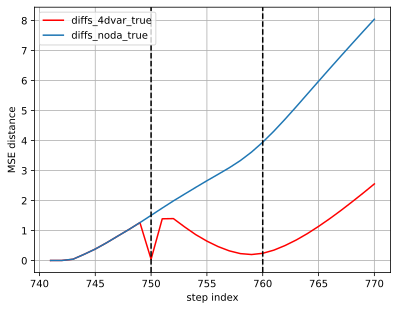

diffs_noda_real_mse[da_idxs[0]]=tensor(1.5085), diffs_noda_real_mse[da_idxs[1]]=tensor(3.9464)
diffs_da_real_mse[da_idxs[0]]=tensor(0.0459), diffs_da_real_mse[da_idxs[1]]=tensor(0.2437)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(0.2387), diffs_noda_real_rrmse[da_idxs[1]]=tensor(0.3860)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.0417), diffs_da_real_rrmse[da_idxs[1]]=tensor(0.0959)
diffs_noda_real_ssim[da_idxs[0]]=np.float32(0.28927046), diffs_noda_real_ssim[da_idxs[1]]=np.float32(0.714897)
diffs_da_real_ssim[da_idxs[0]]=np.float32(0.93100744), diffs_da_real_ssim[da_idxs[1]]=np.float32(0.8519608)


In [21]:
step_idxs = list(range(start_da_end_idxs[0] + 1, start_da_end_idxs[-1] + 1))

plt.plot(step_idxs, diffs_da_real_mse, color="r", label="diffs_4dvar_true")
plt.plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_true")
for x in time_obs:
    plt.axvline(x=x, color="k", linestyle="--")
plt.xlabel("step index")
plt.ylabel("MSE distance")
plt.grid(True)
plt.legend()

plt.show()

da_idxs = [9, 19]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}")

750
6068.1274
568.8358
760
10913.848
2325.32


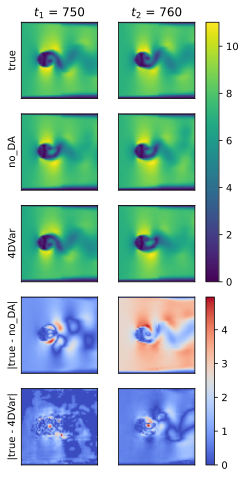

In [22]:
fig, ax = plt.subplots(5, len(da_idxs), figsize=(2 * len(da_idxs), 8), sharex=True)
for x in ax.flat:
    x.set_xticks([])
    x.set_yticks([])
    x.set_xticklabels([])
    x.set_yticklabels([])

setup_cmap = True
with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        img_tensor = (real_img[time_obs[i], 0, ...] ** 2 + real_img[time_obs[i], 1, ...] ** 2) ** 0.5
        # img_tensor = (real_img[750, 0, ...] ** 2 + real_img[750, 1, ...] ** 2) ** 0.5
        print(time_obs[i])
        im1 = ax[0, i].imshow(torch.reshape(img_tensor, (64, 64)), cmap="viridis")
        if setup_cmap:
            # Create a ScalarMappable object with the colormap from images
            sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)
        no_da = forward_model.K_S_preimage(outs_no_4d_da[da_idx]).cpu()
        da = forward_model.K_S_preimage(outs_4d_da[da_idx]).cpu()

        de_no_da = denorm(no_da)
        de_da = denorm(da)

        image_noda = (de_no_da[0, 0, ...] ** 2 + de_no_da[0, 1, ...] ** 2) ** 0.5
        image_da = (de_da[0, 0, ...] ** 2 + de_da[0, 1, ...] ** 2) ** 0.5

        print(np.sum(np.abs(img_tensor.numpy() - image_noda.numpy())))
        print(np.sum(np.abs(img_tensor.numpy() - image_da.numpy())))

        ax[1, i].imshow(torch.reshape(image_noda, (64, 64)), cmap="viridis")
        ax[2, i].imshow(torch.reshape(image_da, (64, 64)), cmap="viridis")
        res = (img_tensor.reshape((64, 64)) - image_noda.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        im2 = ax[3, i].imshow(res, cmap="coolwarm")
        if setup_cmap:
            sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
        res = (img_tensor.reshape((64, 64)) - image_da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        ax[4, i].imshow(res, cmap="coolwarm")
        setup_cmap = False

for i, title in enumerate([f"$t_1$ = {time_obs[0]}", f"$t_2$ = {time_obs[1]}"]):
    ax[0, i].set_title(title)
# ax[0].set_title("$t$")
for i, ylabel in enumerate(["true", "no_DA", "4DVar", "|true - no_DA|", "|true - 4DVar|"]):
    ax[i, 0].set_ylabel(ylabel)

# # Create a ScalarMappable object with the colormap from images
# sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm1.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
# fig.colorbar(sm1, ax=ax, orientation="vertical")

fig.colorbar(sm1, ax=ax[:-2, :], orientation="vertical")
sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[-2:, :], orientation="vertical")

plt.show()